# Test Classifiers and Regressors on train / test data set

In [1]:
import numpy as np
import math
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,SVR,LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score,roc_curve, auc, get_scorer, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy.stats import spearmanr, pearsonr
from matplotlib import pyplot 
from sklearn import linear_model,neighbors,tree,gaussian_process,ensemble,neural_network, manifold,mixture

## Parameters

In [2]:
import sys
sys.version
sys.version_info

sys.version_info(major=2, minor=7, micro=12, releaselevel='final', serial=0)

In [3]:
rel = "./"
train_data_file = rel+"features.csv"
test_data_file = rel+"features/STS/2012-en-test.csv"
cv_fold = 10

#train_reference_data_file = rel +"dataset/STS/2012-en-train.csv"
#test_reference_data_file = rel +"dataset/STS/2012-en-test.csv"

threshold = 0.7

## Classifiers to test

In [4]:
classifiers = [
    #['SVC-linear',SVC(kernel="linear", C=0.025, probability = True)],
    #['SVC-rbf',SVC(gamma=2, C=1, probability = True,decision_function_shape ='ovr')],
    #['KNN-3',KNeighborsClassifier(3)],
    #['KNN-5',KNeighborsClassifier(5)],
    #['KNN-7',KNeighborsClassifier(7)],
    #['DTC-5',DecisionTreeClassifier(max_depth=5)],
    #['DTC-10',DecisionTreeClassifier(max_depth=10)],
    #['DTC-15',DecisionTreeClassifier(max_depth=15)],
    ['RFC-5-10',RandomForestClassifier(max_depth=5, n_estimators=10)],
    ['RFC-10-10',RandomForestClassifier(max_depth=10, n_estimators=10)],
    ['RFC-15-10',RandomForestClassifier(max_depth=15, n_estimators=10)],
    ['RFC-15-20',RandomForestClassifier(max_depth=15, n_estimators=20)],
    ['RFC-15-30',RandomForestClassifier(max_depth=15, n_estimators=30)],
    ['RFC-25',RandomForestClassifier(max_depth=25, n_estimators=50)],
    ['RFC-30',RandomForestClassifier(max_depth=30, n_estimators=50)],
    ['RFC-45',RandomForestClassifier(max_depth=45, n_estimators=50)],
    #['RFC',RandomForestClassifier()],
    #['ADA',AdaBoostClassifier()],
    #['GNB',GaussianNB()],
    #['LDA',LinearDiscriminantAnalysis()],
    #['QDA',QuadraticDiscriminantAnalysis()]
]

## Regressors to test

In [5]:
regressors = [
    #SVR(kernel="linear", C=0.025),
    #SVR(gamma=2, C=1),
    #mixture.GaussianMixture(1),
    #mixture.GaussianMixture(2),
    #mixture.GaussianMixture(3),
    linear_model.LinearRegression(),
    #linear_model.Ridge(alpha = .5),
    #linear_model.ElasticNet(),
    #linear_model.BayesianRidge(),
    ensemble.RandomForestRegressor(),
    ensemble.RandomForestRegressor(max_depth=15, n_estimators=30),
    ensemble.GradientBoostingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.AdaBoostRegressor(),
    gaussian_process.GaussianProcessRegressor(),
    linear_model.HuberRegressor(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.RANSACRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.SGDRegressor(),
    neighbors.KNeighborsRegressor(),
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor(),
    neural_network.MLPRegressor(activation='logistic',solver='lbfgs',max_iter=200)
    
]

## Load data

In [6]:
import csv, json

import io
import csv

def parse(data_file, sep):
    d = pd.read_csv(data_file, delimiter=',', header=None).as_matrix()
    pairs = d[:,0:2]
    x = d[:,2:-1]
    y = d[:,-1]
    return x,y,pairs

In [7]:
def multiclass(y_class):
    y = np.zeros([len(y_class),len(np.unique(y_class))])
    for idx, val in enumerate(y_class):
        y[idx,int(val)]=1
    return y

In [8]:
x_train,y_train,pairs_train = parse(train_data_file,sep=',')

In [9]:
x_train.shape

(2234L, 28L)

In [10]:
y_train_class = (y_train >= threshold).astype(int)
y_train_mul = multiclass(y_train_class)

In [11]:
x_test,y_test,pairs_test  = parse(test_data_file,sep=',')

In [12]:
x_test.shape

(3108L, 28L)

In [13]:
y_test_class = (y_test >= threshold).astype(int)
y_test_mul = multiclass(y_test_class)

In [14]:
y_test_class

array([1, 0, 0, ..., 1, 1, 1])

In [15]:
pd.DataFrame(x_train).head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.922951,0.462363,-0.717897,0.487135,0.272088,1,0,0.0959827,0.2,0.719335,...,0,9.2142,0,0,0,0,6.06546,0,0,2.80532
1,0.84703,0.501617,-1.25638,0.197028,0.324462,1,0,0.0228606,0.230286,0.8,...,0,10.1016,0,9.38484,0,5.56304,0,5.74537,0,13.2843
2,0.844538,0.39048,-0.905008,0.231846,0.236477,0.8,0,0.0325217,0.2,0.5,...,0,5.49856,7.70759,8.65731,4.68008,22.891,0,0,4.30659,3.01595
3,0.858369,0.464694,-1.28953,0.259366,0.336664,1,0,0,0.2,0.8,...,0,0,0,0,0,10.8435,0,0,0,20.9682
4,0.656541,0.492786,-1.12096,0.261499,0.318566,1,0,0.043519,0.210664,0.757841,...,0,0.154158,0,10.7482,0,0,0,5.74537,0,12.1838


In [16]:
pd.DataFrame(x_test).head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.778486,0.4983,-1.66992,-0.120717,0.290759,0.8,0.0412438,0.0412438,0.253105,0.8,...,0,0,0,0,0,0,0,0,0,7.2552
1,0.713702,0.420974,-0.853733,0.435539,0.262794,0.8,0,0,0.275827,0.8,...,0,0,7.27897,10.438,0,0,0,0,0,1.32273
2,0.59247,0.38001,-0.895615,0.55703,0.234505,0.8,0.05202,0.0575646,0.200878,0.537725,...,0,0,0,0,0,0,0,0,0,11.5984
3,0.580054,0.273451,-0.273268,-0.0704805,0.138999,0.5,0,0,0.2,0.369359,...,0,0,0,0,0,0,10.8435,0,0,14.3102
4,0.651826,0.311364,0.592991,1.25371,0.337002,1,0,0,0.0630641,0.37643,...,0,0,0,0,0,11.5367,0,0,0,22.0842


# Represent data

## Select features

### Roc curve generator

In [17]:
def plot_roc_curve(y_test, y_score):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    pyplot.figure()
    lw = 2
    pyplot.plot(fpr["micro"],tpr["micro"], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
    pyplot.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    pyplot.xlim([0.0, 1.0])
    pyplot.ylim([0.0, 1.05])
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title('Receiver operating characteristic')
    pyplot.legend(loc="lower right")
    pyplot.show()

## Score classifiers

In [18]:
import sklearn.pipeline as pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import BaggingClassifier
classifiers_scores = []

# iterate over classifiers
#for clf in classifiers:
#    y_score = clf.fit(x_train, y_train_class).predict(x_test)
#    sc = get_scorer('f1')(clf,x_test,y_test_class)
#    classifiers_scores.append(sc)
    
    
    
classifiers_scores = []
classifiers_regr = []
# iterate over classifiers
for name,clf in classifiers:
    #clf =  ensemble.VotingClassifier(classifiers,voting='soft')
    y_score_clf_test = clf.fit(x_train, y_train_class).predict_proba(x_test)
    y_score_clf_train = clf.predict_proba(x_train)
    #score_max = f1_score(y_train_class, y_score_clf[:,1]>0.5)
    score_max = pearsonr(y_test,y_score_clf_test[:,1])[0]
    regr_max = None
    for regr in regressors: 
        x_train_ext = np.append(x_train, y_score_clf_train, 1)
        x_test_ext  = np.append(x_test, y_score_clf_test, 1)
        y_score = regr.fit(x_train_ext,y_train).predict(x_test_ext)
        #score = f1_score(y_train_class, y_score>0.5)
        score = pearsonr(y_test,y_score)[0]
        if score > score_max:
            score_max = score
            regr_max = regr
    classifiers_scores.append(score_max)
    classifiers_regr.append(regr_max)

In [19]:
pd.DataFrame({"Classifier":[name for name,classifier in classifiers],\
              "Pearson":classifiers_scores},\
             columns=["Classifier","Pearson"]\
            )

,Classifier,Pearson
0,RFC-5-10,0.707851
1,RFC-10-10,0.692301
2,RFC-15-10,0.689205
3,RFC-15-20,0.713694
4,RFC-15-30,0.705716
5,RFC-25,0.715911
6,RFC-30,0.717549
7,RFC-45,0.704324


## Evaluate features

In [43]:
import sklearn.metrics as metrics

clas_threshold = 0.6
c_eval = pd.DataFrame(index=range(0,x_train.shape[1]), columns=['F1','Pearson','Precision','Recall','Accuracy'])
for i in range(0,x_train.shape[1]):
    y_score_cl = (x_test[:,i] > clas_threshold).astype(int)
    c_eval['F1'][i] = metrics.f1_score(y_test_class, y_score_cl)
    c_eval['Pearson'][i] = pearsonr(y_test,x_test[:,i])[0]
    c_eval['Precision'][i] = metrics.precision_score(y_test_class, y_score_cl)
    c_eval['Recall'][i] = metrics.recall_score(y_test_class, y_score_cl)
    c_eval['Accuracy'][i] = metrics.accuracy_score(y_test_class, y_score_cl)

In [44]:
c_eval.T

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
F1,0.782152,0.183085,0.0663738,0.258746,0,0.749892,0.0175631,0.0175631,0.0326619,0.736013,...,0.15171,0.20017,0.270802,0.290456,0.273407,0.328978,0.403705,0.0551583,0.223438,0.669403
Pearson,0.660406,0.557305,-0.327409,-0.394217,0.256992,0.420329,0.231185,0.247886,0.413789,0.522667,...,0.0887672,-0.0273575,-0.173476,0.0423456,0.0750548,-0.00943221,0.117905,-0.0843128,0.0717858,-0.107745
Precision,0.687212,0.901961,0.279835,0.378465,0,0.61338,1,1,0.967742,0.70015,...,0.725118,0.427536,0.427208,0.57947,0.663113,0.537688,0.666242,0.355263,0.633075,0.568992
Recall,0.90753,0.101883,0.0376523,0.196567,0,0.964563,0.00885936,0.00885936,0.0166113,0.775748,...,0.0847176,0.130676,0.198228,0.193798,0.172204,0.236988,0.28959,0.0299003,0.135659,0.812846
Accuracy,0.706242,0.471686,0.384492,0.34556,0.418919,0.626126,0.424067,0.424067,0.42825,0.676641,...,0.449485,0.393179,0.379665,0.449807,0.468147,0.438224,0.502896,0.404762,0.452059,0.533462


In [45]:
c_eval.T[0]

F1           0.782152
Pearson      0.660406
Precision    0.687212
Recall        0.90753
Accuracy     0.706242
Name: 0, dtype: object

## The best classifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
Pearson:	0.718
F1:		0.787
Precision:	0.679
Recall:		0.936
Accuracy:	0.706
             precision    recall  f1-score   support

      False       0.81      0.39      0.52      1302
       Tr

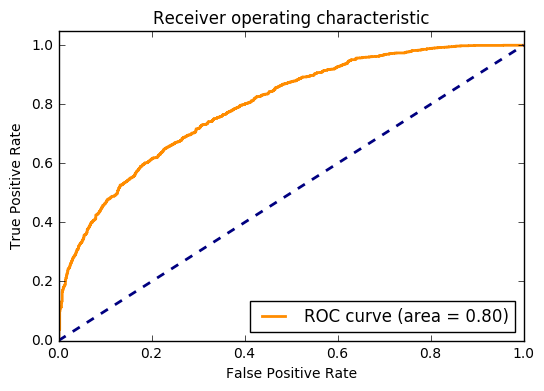

In [33]:
import sklearn.metrics as metrics

max_cls = np.where(classifiers_scores == max(classifiers_scores))[0][0]
clf = classifiers[max_cls][1]
regr = classifiers_regr[max_cls]
print(clf)
y_score_clf = clf.predict_proba(x_test)
y_score_clf_train = clf.predict_proba(x_train)
if regr is not None:
    print(regr)
    x_train_ext = np.append(x_train, y_score_clf_train, 1)
    x_test_ext  = np.append(x_test, y_score_clf, 1)
    y_score = regr.fit(x_train_ext,y_train).predict(x_test_ext)
else:
    print('No regression')
    y_score = y_score_clf[:,1]
print("Pearson:\t%0.3f"%pearsonr(y_test,y_score)[0])
print("F1:\t\t%0.3f"%metrics.f1_score(y_test_class,y_score>0.5))
print("Precision:\t%0.3f"%metrics.precision_score(y_test_class,y_score>0.5))
print("Recall:\t\t%0.3f"%metrics.recall_score(y_test_class,y_score>0.5))
print("Accuracy:\t%0.3f"%metrics.accuracy_score(y_test_class,y_score>0.5))


print(classification_report(y_test_class, y_score>0.5, target_names=['False', 'True']))
plot_roc_curve(y_test_class,y_score)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Pearson:	0.660
F1:		0.859
Accuracy:	0.795
Precision:	0.884
Recall:		0.835


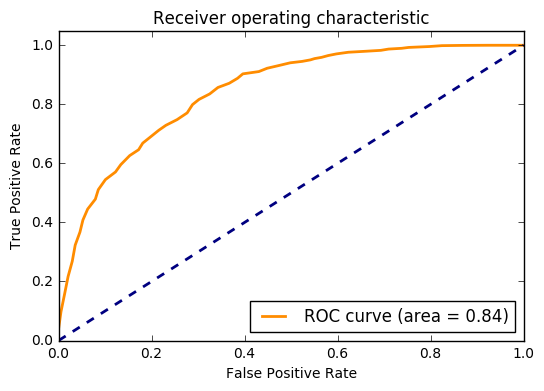

             precision    recall  f1-score   support

      False       0.58      0.68      0.62       785
       True       0.88      0.84      0.86      2323

avg / total       0.81      0.79      0.80      3108



In [24]:
clf = classifiers[np.where(classifiers_scores == max(classifiers_scores))[0][0]][1] 
print(clf)
y_score = clf.predict_proba(x_test)
print("Pearson:\t%0.3f"    %pearsonr(y_test,y_score[:,1])[0])
print("F1:\t\t%0.3f"       %get_scorer('f1')(clf,x_test,y_test_class))
print("Accuracy:\t%0.3f"   %get_scorer('accuracy')(clf,x_test,y_test_class))
print("Precision:\t%0.3f"  %get_scorer('precision')(clf,x_test,y_test_class))
print("Recall:\t\t%0.3f"   %get_scorer('recall')(clf,x_test,y_test_class))
plot_roc_curve(y_test_class,y_score[:,1])
print(classification_report(y_test_class, y_score[:,1]>0.5, target_names=['False', 'True']))
y_score_class = clf.predict(x_test)

In [25]:
from sklearn.externals import joblib
joblib.dump(clf,type(clf).__name__ +'_'+str(threshold)+'.pkl')

['RandomForestClassifier_0.6.pkl']

In [26]:
out_regr_err = 'class.res.csv'
columns = ['Plag','Truth','Classification','Diff','Str1','Str2']
pd.DataFrame(np.array([y_test,y_test_class,y_score_class,y_test_class-y_score_class,pairs_test[:,0],pairs_test[:,1]]).T,columns=columns).to_csv(out_regr_err)

## Score regressors

In [27]:
regressors_scores = []
for rgs in regressors:
    y_score = rgs.fit(x_train, y_train).predict(x_test)
    regressors_scores.append(pearsonr(y_test,y_score)[0])

In [28]:
pd.DataFrame({"Regressor":[type(regressor).__name__ for regressor in regressors],\
              "Pearson":regressors_scores},\
             columns=["Regressor","Pearson"])

,Regressor,Pearson
0,LinearRegression,0.673025
1,RandomForestRegressor,0.684878
2,RandomForestRegressor,0.696621
3,GradientBoostingRegressor,0.708211
4,ExtraTreesRegressor,0.671825
5,BaggingRegressor,0.678497
6,AdaBoostRegressor,0.676718
7,GaussianProcessRegressor,0.217662
8,HuberRegressor,0.669001
9,PassiveAggressiveRegressor,0.554451


## The best regressor

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)


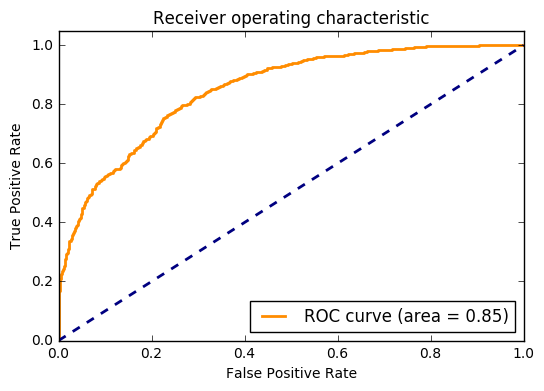

Spearman:	0.628
Pearson:	0.708
Accuracy:	0.768
             precision    recall  f1-score   support

      False       0.53      0.75      0.62       785
       True       0.90      0.77      0.83      2323

avg / total       0.81      0.77      0.78      3108



In [29]:
m_r = np.where(regressors_scores == max(regressors_scores))[0][0]
rgs = regressors[m_r] 
print(rgs)
y_score = rgs.predict(x_test)
y_score_bin = (y_score >=threshold).astype(int)
plot_roc_curve((y_test_class),(y_score))

print("Spearman:\t%0.3f"%spearmanr(y_test,y_score).correlation)
print("Pearson:\t%0.3f" %pearsonr(y_test,y_score)[0])
print("Accuracy:\t%0.3f" % (accuracy_score(y_test_class, y_score_bin)))
print(classification_report(y_test_class, y_score_bin, target_names=['False', 'True']))

In [30]:
out_regr_err = 'regr.res.csv'
columns = ['Truth','Score','Diff','Abs_Diff','Str1','Str2']
pd.DataFrame(np.array([y_test,y_score,y_test-y_score,abs(y_test-y_score),pairs_test[:,0],pairs_test[:,1]]).T,columns=columns).to_csv(out_regr_err)